<a href="https://colab.research.google.com/github/samarth-91/Airbnb-Data-Analysis/blob/main/Airbnb_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [4]:
#read the dataset
listings_df = pd.read_csv('/content/drive/MyDrive/air bnb dataset/listings.csv')

#find number of listings and number of hosts
listings_number = listings_df['id'].count()
hosts_number = len(listings_df['host_id'].unique())

print('listings.csv dataset contains information on %d listings provided by %d hosts.' % (listings_number,
                                                                                          hosts_number))

listings.csv dataset contains information on 3818 listings provided by 2751 hosts.


<Axes: title={'center': 'Missing values per column, %'}>

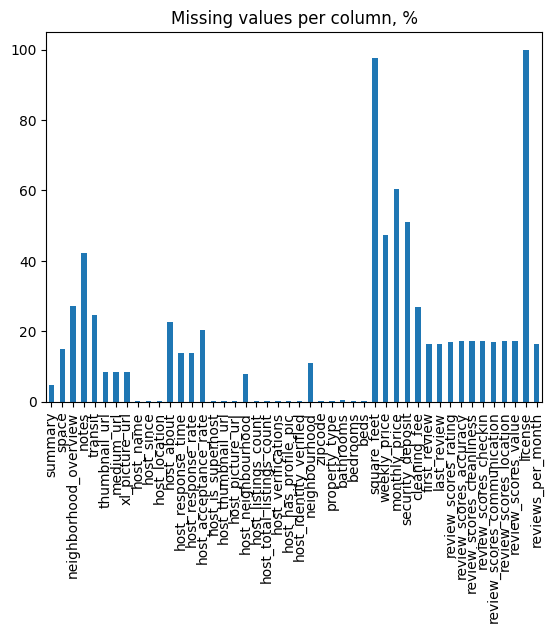

In [5]:
#find percentage of missing values for each column
listings_missing_df = listings_df.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#plot the results
listings_columns_with_nan.plot.bar(title='Missing values per column, %')

In [6]:
#read the dataset
calendar_df = pd.read_csv('/content/drive/MyDrive/air bnb dataset/calendar.csv')

#find number of rows in dataset
rows_num = calendar_df.shape[0]

#find first and last date of the calendar
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()

print('calendar.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))

calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.


<Axes: title={'center': 'Missing values per column, %'}>

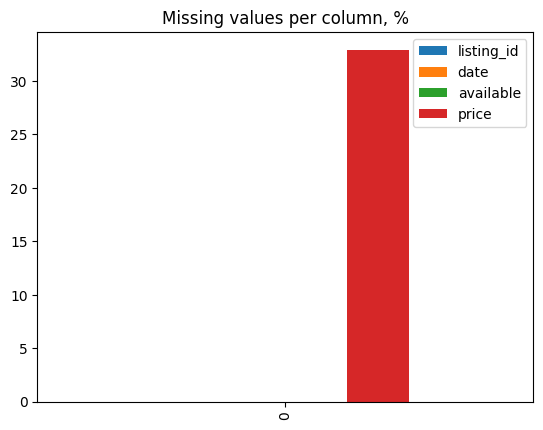

In [7]:
#get percentage of missing values for each column in dataset
calendar_missing_df = pd.DataFrame([calendar_df.isnull().mean()*100])

#plot the results
calendar_missing_df.plot.bar(title='Missing values per column, %')

In [12]:
#Helper functions for dataset cleaning

def get_month_from_date(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''

    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique():
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0

    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)

    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)

    return

def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Main dataset cleaning function
def clean_dataset(listings_df, calendar_df):
    '''
    INPUT
    listings_df - pandas dataframe containing listings data
    calendar_df - pandas dataframe containing calendar data

    OUTPUT
    df - cleaned dataset, which contains merged tables:
    1. irrelevant columns are dropped;
    2. string containing dates are converted into numbers;
    3. columns, containing lists, are split into several columns (for example, amenities)
    4. missing values are imputed with mean or mode.
    '''
    #merge datasets
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')

    #drop the irrelevant columns
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)

    #convert date from the calendar into month and drop the date colum
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])

    #remove rows where price_x == nan, because price will be used as response column
    df = df.dropna(subset=['price_x'])

    #convert price to number and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace('[\$,]', '', regex=True).astype(float)
    df = df.drop(columns = ['price_x'])

    #convert host_since date into number and fill in missing values, drop the original column
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])

    #convert host_response_rate into number and fill in missing values, drop the original column
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)

    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')

    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])

    #fill missing values with mean value for host_listings_count
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)

    #split host_verifications into dummy columns and drop the original column
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])

    #fill in missing values for bathrooms, bedrooms and beds with mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])

    #split amenities into dummy columns and drop the original column
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])

    #turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])

    #fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)

    return df

In [14]:
def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''

    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique():
        # Handle potential float values
        if isinstance(unique_value, str):
            for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
                if value in values_dict:
                    values_dict[value] = values_dict[value] + 1
                else:
                    values_dict[value] = 0

    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)

    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)

    return

In [16]:
# apply functions above to clean dataset
df = clean_dataset(listings_df, calendar_df)

In [31]:
#find minimum, maximum and average price for listing
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()

# Use %f or %.2f for formatting floats
print('Minimum price per listing is %.2f$.' % (min_price))
print('Maximum price per listing is %.2f$.' % (max_price))
print('Average price per listing is %.2f$.' % (mean_price))

Minimum price per listing is 10.00$.
Maximum price per listing is 1650.00$.
Average price per listing is 137.94$.


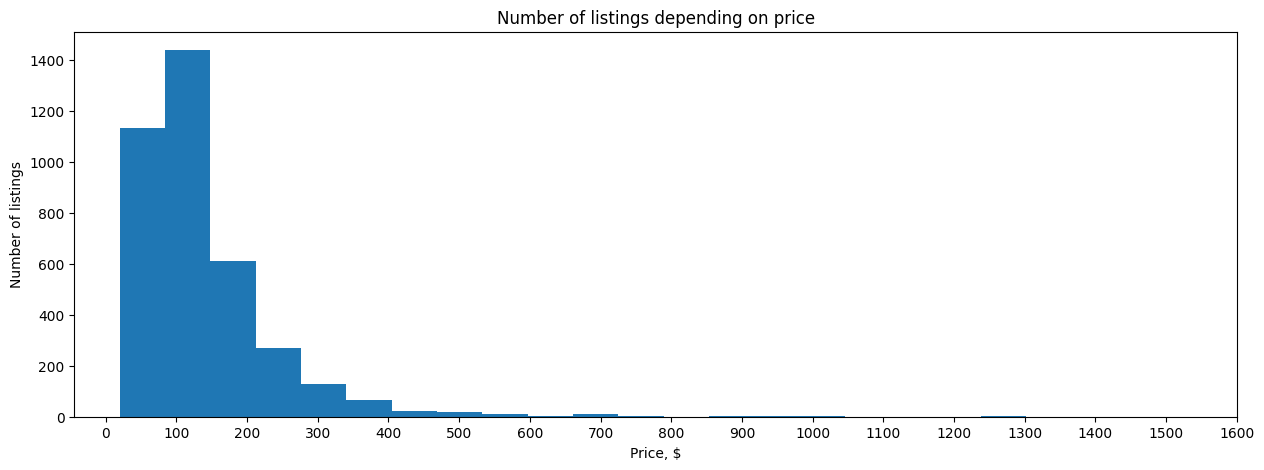

In [32]:
# Convert the 'price' column to numeric, handling errors
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Now calculate the mean price for each listing
mean_price_for_listing = df.groupby('listing_id')['price'].mean()

# Proceed with plotting
plt.figure(figsize=(15,5))
plt.hist(mean_price_for_listing, bins=20)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('Number of listings')
plt.xlabel('Price, $') # Close the quotes here
plt.title('Number of listings depending on price')

plt.savefig('Price distrubution.png')

plt.show()

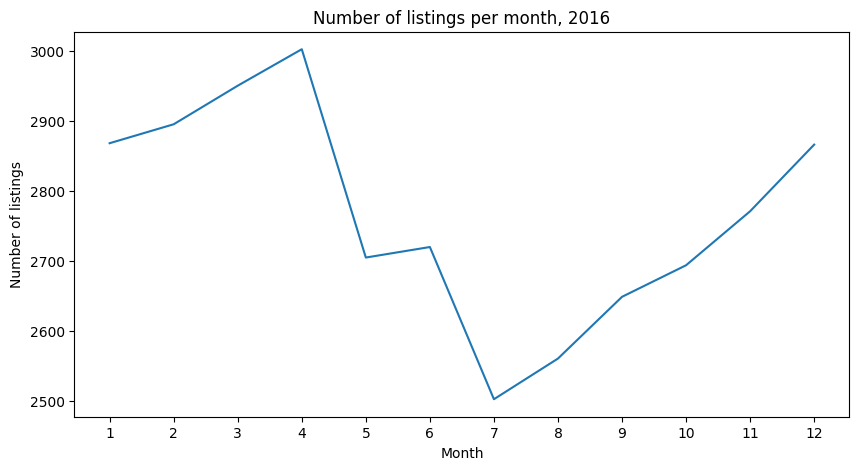

In [33]:
#find number of total number of listings for each month in 2016
number_of_listings_by_month = pd.Series([12])
for i in range(1, 13):
    number_of_listings_by_month[i] = len(df[(df['month'] == i) & (df['year'] == 2016)]['listing_id'].unique())

number_of_listings_by_month = number_of_listings_by_month.drop(0)

#plot
plt.figure(figsize=(10,5))
plt.plot(number_of_listings_by_month)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')

plt.savefig('number of available listings.png')

plt.show()

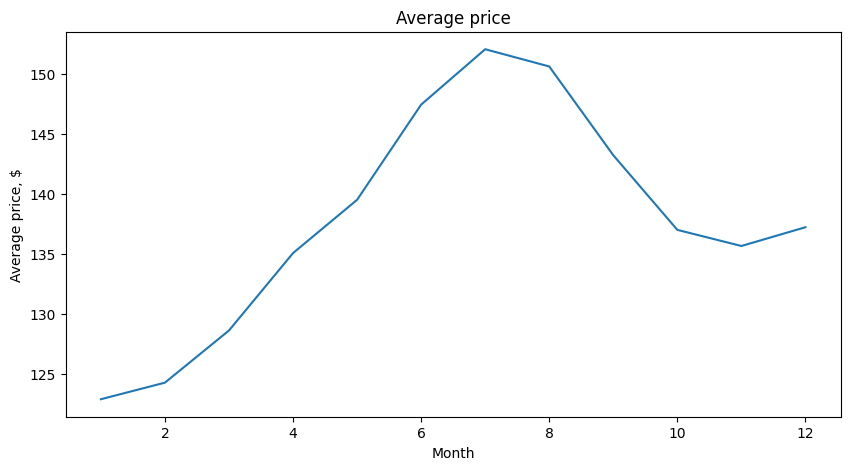

In [34]:
#find average price by month
average_price_by_month = df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')

plt.savefig('average price for month')

plt.show()

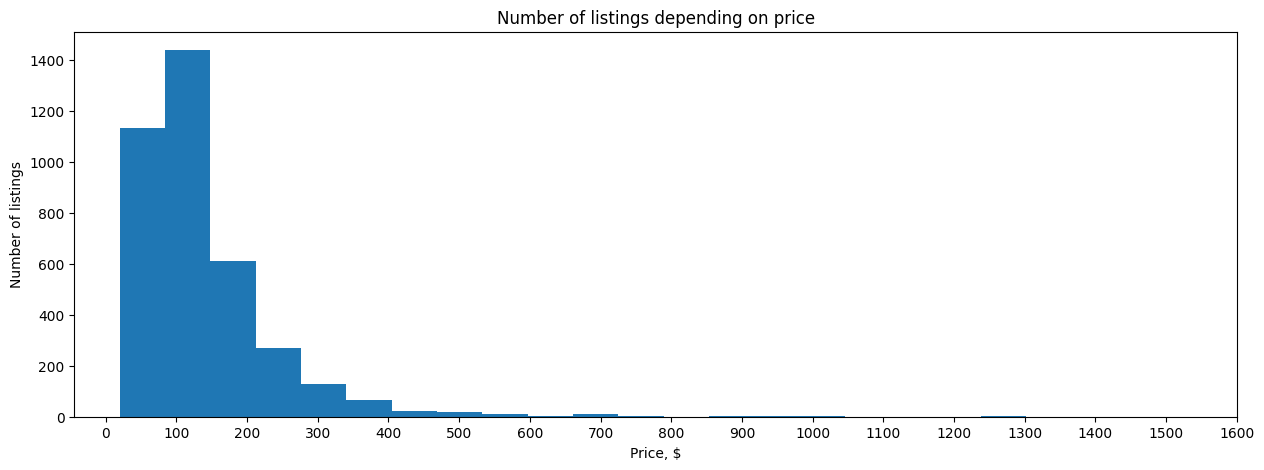

In [36]:
# Convert the 'price' column to numeric, handling errors
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Remove rows with missing price values
df = df.dropna(subset=['price'])

# Now calculate the mean price for each listing
mean_price_for_listing = df.groupby('listing_id')['price'].mean()

# Proceed with plotting
plt.figure(figsize=(15,5))
plt.hist(mean_price_for_listing, bins=20)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('Number of listings')
plt.xlabel('Price, $') # Close the quotes here
plt.title('Number of listings depending on price')

plt.savefig('Price distrubution.png')

plt.show()

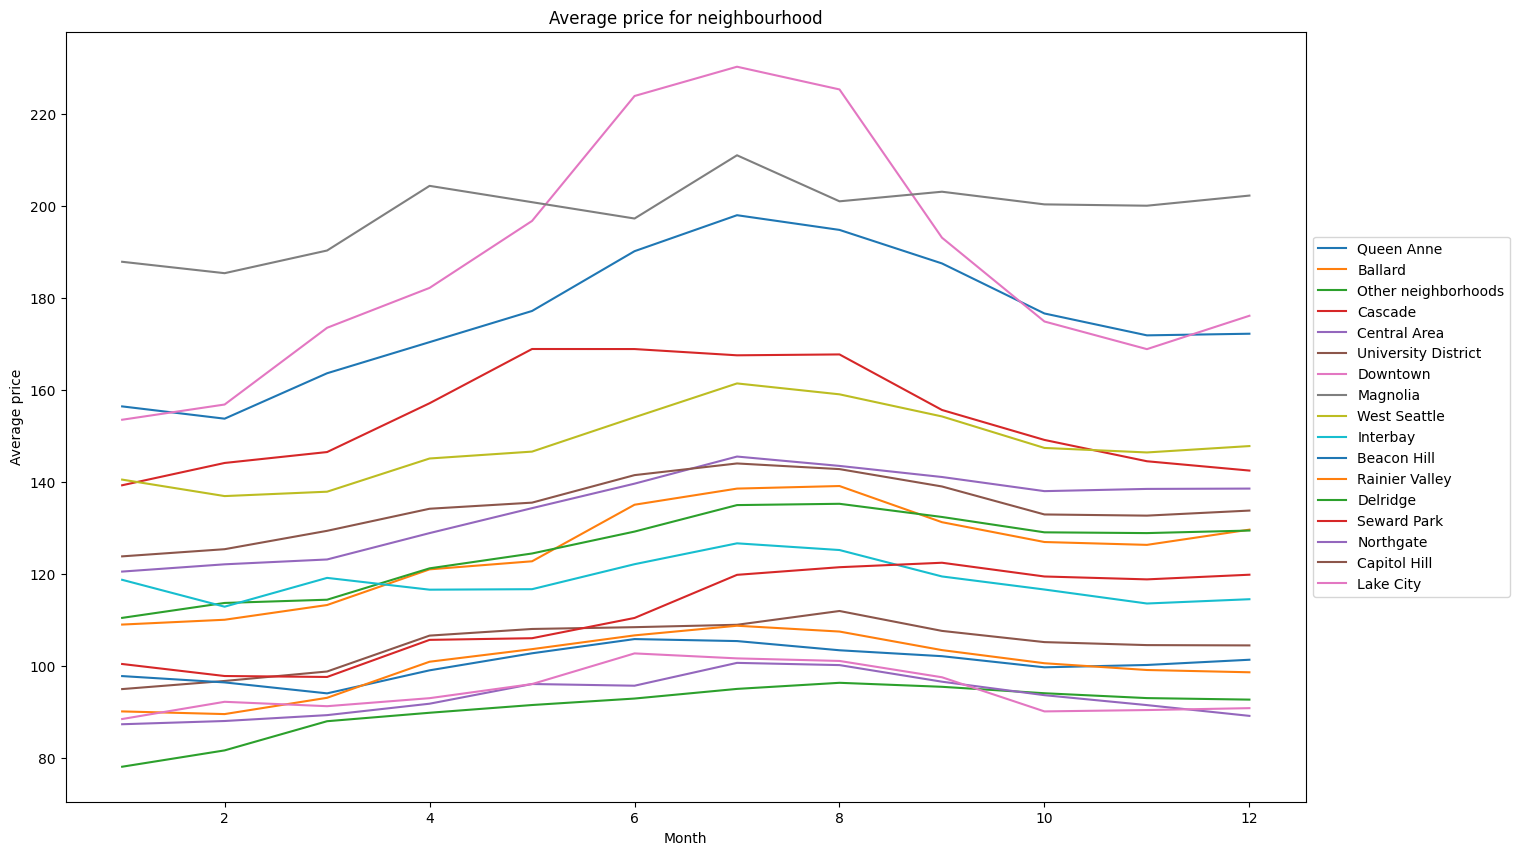

In [38]:
#get list of neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

# Convert 'price' column to numeric, handling errors
df['price'] = pd.to_numeric(df['price'], errors='coerce')

#get prices by month and neighbourhood
price_by_month_neighbourhood = df.groupby(['month','neighbourhood_group_cleansed'])['price'].mean().reset_index()

#plot prices for each neighbourhood
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
             price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
             label = neighbourhood)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Average price') # Removed extra comma and closing parenthesis
plt.xlabel('Month')
plt.title('Average price for neighbourhood') # Removed extra comma and closing parenthesis

plt.savefig('average price for neighbourhood')

plt.show()

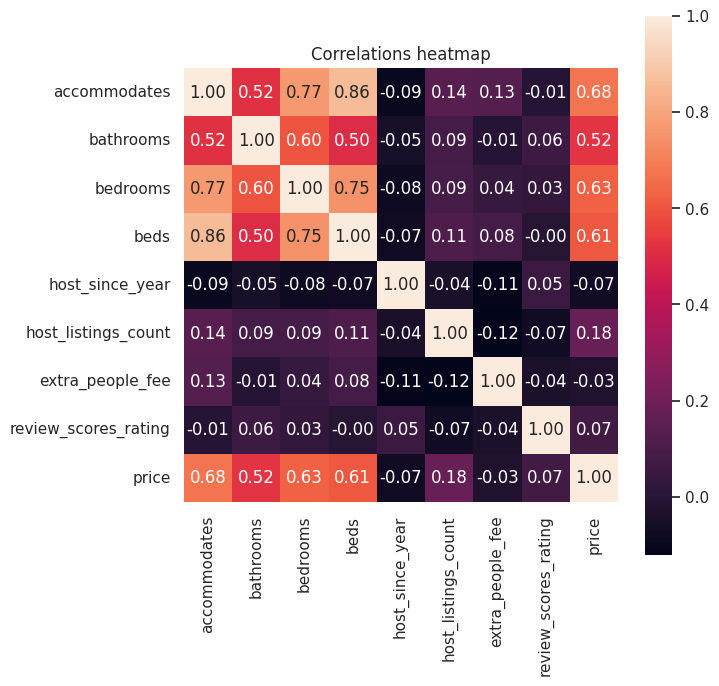

In [39]:
#Numerical columns to find out correlation
cols = ['accommodates','bathrooms','bedrooms','beds','host_since_year',
        'host_listings_count', 'extra_people_fee',
        'review_scores_rating', 'price']

#Find out correlation between columns and plot
corrs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

machne learning

random forrest aggressor

In [40]:
#turn categorical columns into dummies
cat_columns = list(df.select_dtypes(include=['object']).columns)

for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)
#drop listing_id and year columns
df = df.drop(columns = ['listing_id', 'year'])

In [41]:
#prepare train and test datasets for modelling
TEST_SIZE = 0.3
RAND_STATE = 42

X = df.drop(columns = 'price')
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [45]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100,
                               criterion='squared_error',  # Change 'mse' to 'squared_error'
                               random_state=RAND_STATE,
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
             r2_score(y_test, y_test_preds)))

Random Forest MSE train: 186.973, test: 211.258
Random Forest R^2 train: 0.983, test: 0.981


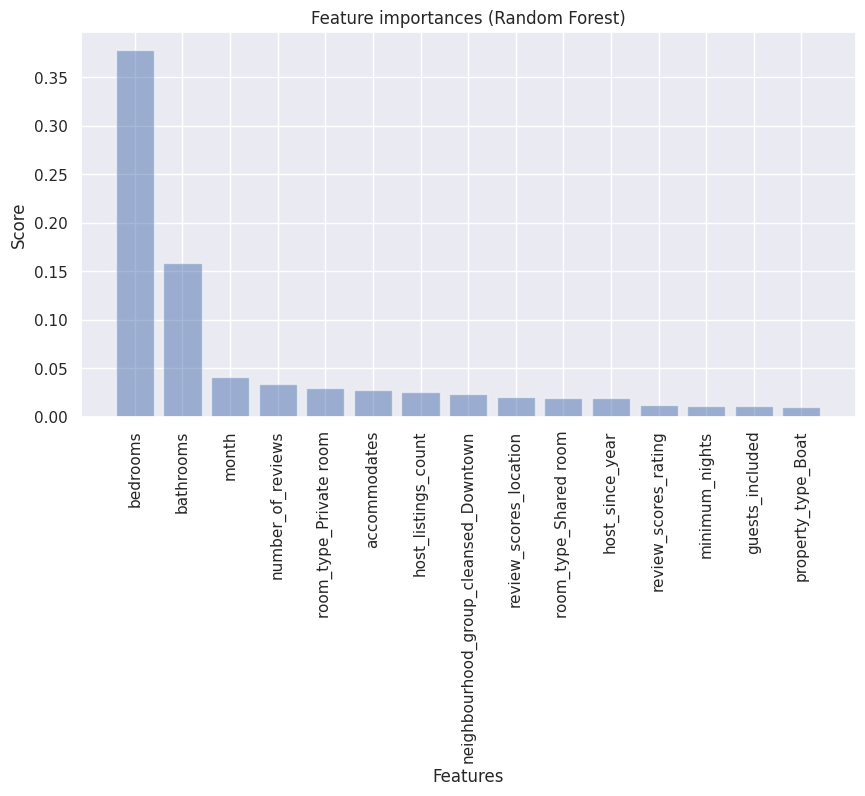

In [46]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')

plt.show()

In [47]:
#train XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

MSE train: 871.320, test: 876.940
R^2 train: 0.922, test: 0.919


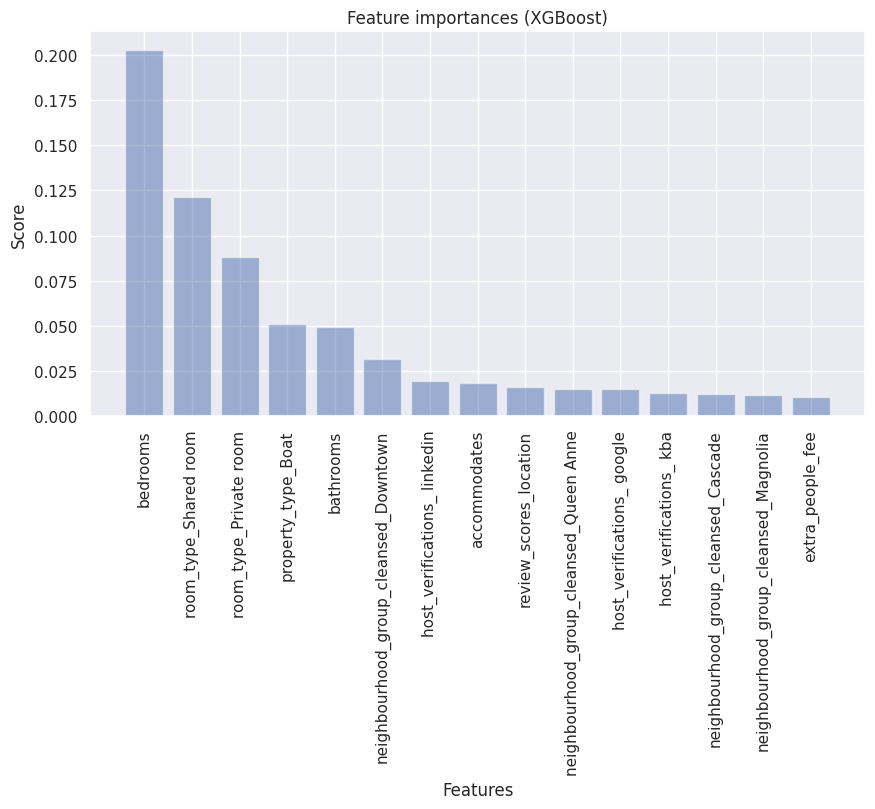

In [48]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 15 features
features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15]

plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('feature importances XGB.png')

plt.show()